# **03** EDA and Pre-Processing / Feature Engineering

### Datasets
- We will be working with 3 datasets to begin which include:
    - df_combined: This includes all of our data (1996-2009)
    - df_train: This includes our df_combined dataset split into a training dataset (1996-2006)
    - df_test: This is going to our dataset of unseen data for which we will test how good our model actually is (2007-2009)
    
### Visualize Data
- Let's determine the top route by passenger volume over the life of our data as a baseline model
- [Visualize Route Data](#Visualize-Route) Upon selection of this route we dive into EDA and visualize the route data
    - Lineplots
    - Decomposition Plots

### [Pre-Processing / Feature Engineering](#Pre-Processing-+-Feature-Engineering)
- Feature Engineering
    - General Features
- ACF & PACF Plots    
    - Trend / Seasonal Features
- Pre-Processing
    - AdFuller Test on each dataseries in our dataframes
    - Engineer features with stationary data

In [627]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.vecm import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen # this is to check for stationarity with Multivariate (DickeyFuller for Univariate)
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [628]:
# Import Datasets
df_combined = pd.read_csv('./data/clean/combined.csv')

# Import TRAIN dataset for modeling - Monthly Data 1996-2006
df_train = pd.read_csv('./data/clean/train.csv')

# Import TEST dataset for applying model on Unseen data - Monthly Data 2007-2009
df_test = pd.read_csv('./data/clean/test.csv')

print(df_combined.shape)
print(df_train.shape)
print(df_test.shape)

(63000, 14)
(49500, 14)
(13500, 14)


In [629]:
# Modify datasets to set index to datetime index

# COMBINED
df_combined.index = pd.to_datetime(df_combined['year-month'])
df_combined = df_combined.drop(columns=['year-month']).sort_index()

# TRAIN
df_train.index = pd.to_datetime(df_train['year-month'])
df_train = df_train.drop(columns=['year-month']).sort_index()

# TEST
df_test.index = pd.to_datetime(df_test['year-month'])
df_test = df_test.drop(columns=['year-month']).sort_index()

We will not need our **df_test** dataset until later in the analysis

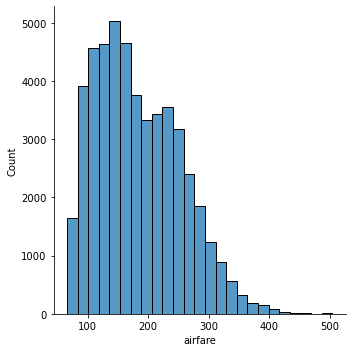

In [630]:
# Look at distribution of all flights
sns.displot(df_train['airfare'], bins=25);

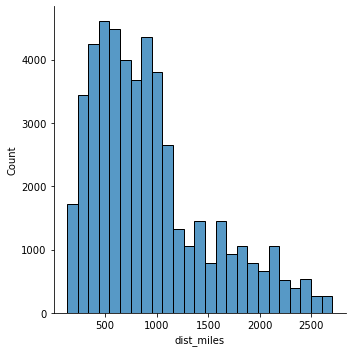

In [631]:
sns.displot(df_train['dist_miles'], bins=25);

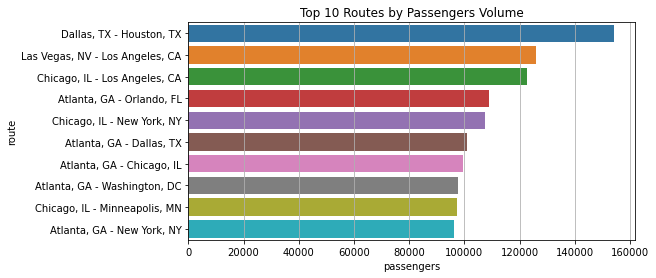

In [632]:
# To begin we will try and predict the top 10 routes by passenger volume

# Which dataset would you like to look at
dataset = df_train

# Which dataseries in the dataset would you like to look at
dataseries = 'passengers'

plt.figure(figsize=(8, 4))
# plt.xticks(rotation=45)
plt.grid()
sns.barplot(data=dataset.groupby('route')[[dataseries]].mean().sort_values(by=dataseries, ascending=False).head(10),
            y=dataset.groupby('route')[[dataseries]].mean().sort_values(by=dataseries, ascending=False).head(10).index, 
            x=dataseries)
plt.title('Top 10 Routes by ' + dataseries.capitalize() + ' Volume');

In [633]:
# Which route do we want to look at?  Enter route and save as variable itinerary
itinerary = 'Dallas, TX - Houston, TX'

# Save the itinerary dataset as it's own dataframe
route = df_train[df_train['route'] == itinerary].copy()

# Save the itinerary dataset as it's own dataframe for later predictions
unseen_route = df_test[df_test['route'] == itinerary].copy()

print(route.shape)
print(unseen_route.shape)

(132, 13)
(36, 13)


## Visualize Route
- Does the data look stationary?  Let's look at it as is and differenced one time
- Does the data include seasonality or trends - let's look at Decompose Plot

In [634]:
drop_columns = ['origin_lat', 'origin_long', 'dest_lat', 'dest_long', 'pop_origin', 'pop_dest', 'dist_miles']

def visualize_route(df=route, itinerary_route=itinerary):
    for i in df._get_numeric_data().drop(columns=drop_columns).columns:
        plt.figure(figsize=(12,2))
        plt.plot(df[i], label=i.capitalize().replace('_', ' '))
        plt.xlabel('Year', size=16)
        plt.ylabel('Total ' + i.capitalize().replace('_', ' '), size=16)
        plt.grid()
        plt.title(str(itinerary_route.upper()) + ":  " + i.replace('_', " ").capitalize())
        plt.legend()
        plt.figure(figsize=(12,2))
        plt.plot(df[i].diff(), label=str(i.capitalize().replace('_', ' ')) + ' 1-Differenced', color='red')
        plt.xlabel('Year', size=16)
        plt.ylabel('Total ' + i.capitalize().replace('_', ' '), size=16)
        plt.grid()
        plt.title(str(itinerary_route.upper()) + ":  " + i.replace('_', " ").capitalize())
        plt.legend()
        seasonal_decompose(df[i]).plot()

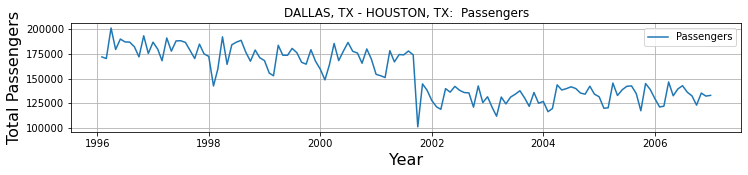

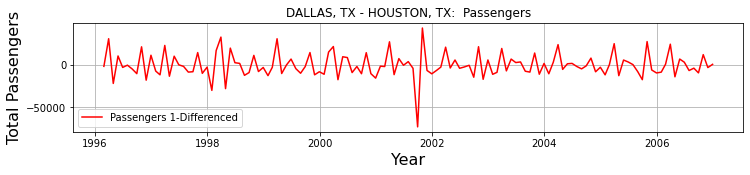

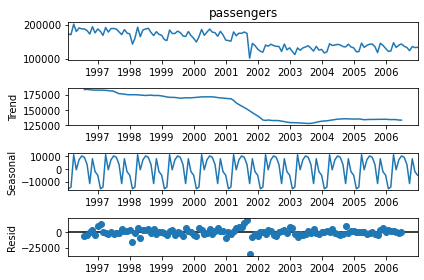

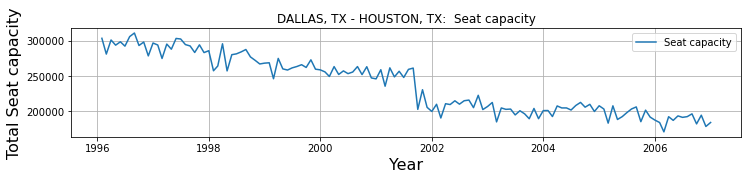

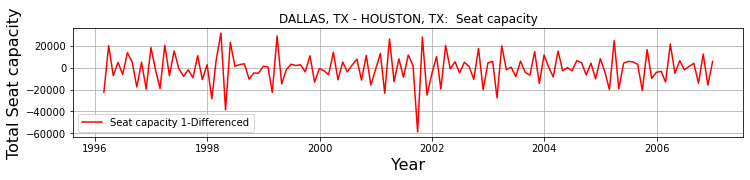

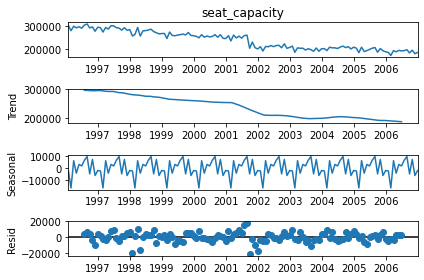

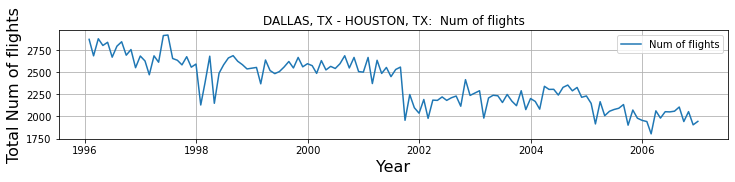

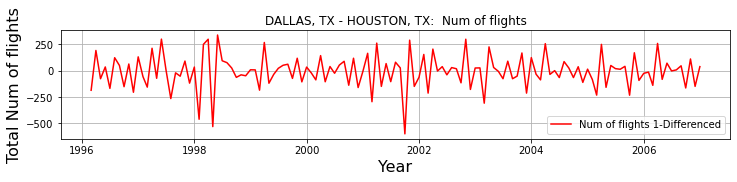

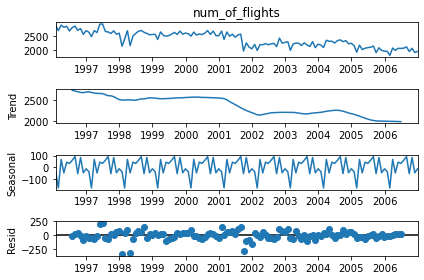

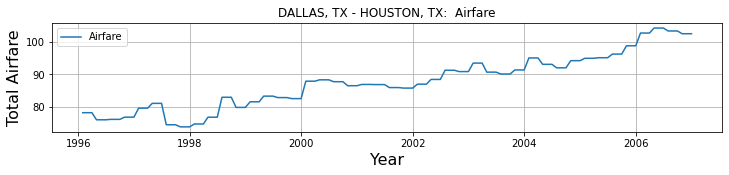

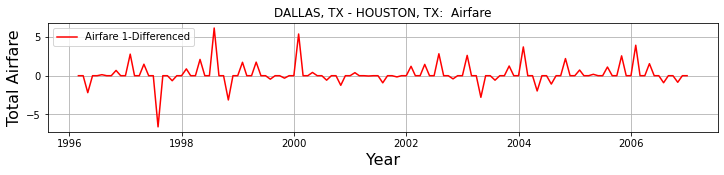

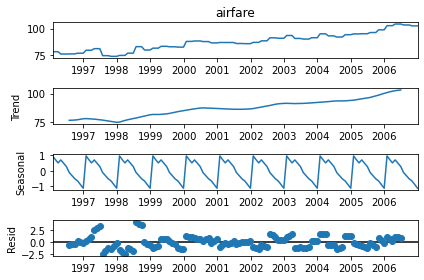

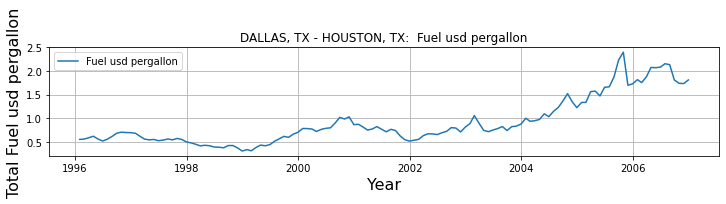

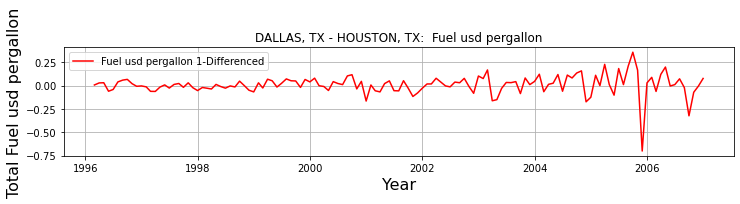

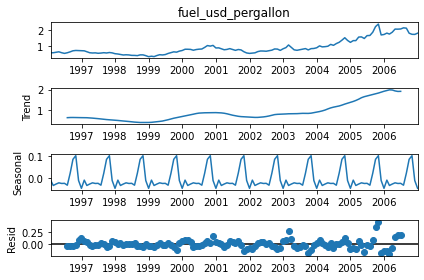

In [635]:
# run function with default settings
visualize_route()

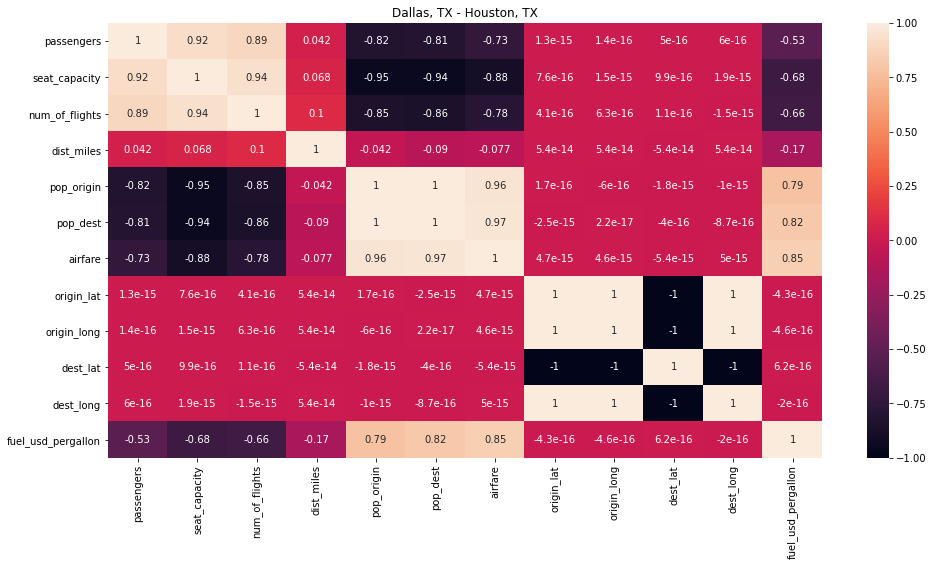

In [636]:
# Taking a look at the heatmap let's see if there are any initial correlations which stand out?

plt.figure(figsize=(16, 8))
sns.heatmap(data = route.corr(), annot=True, vmin=-1.0, vmax=1.0).set(title=itinerary);

# Pre-Processing + Feature Engineering
### Feature Engineering
- [some reference code I helped guide some of this process](https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/#:~:text=Feature%20Engineering%20for%20Time%20Series,as%20a%20supervised%20learning%20problem.&text=So%20that%20we%20can%20train%20a%20supervised%20learning%20algorithm.&text=Lag%20Features%3A%20these%20are%20values,window%20of%20prior%20time%20steps.)

In [637]:
# Here is a function to create different features which may be applicable to our model

def preliminary_features(df): # fixed
    
    df = df.copy()
    df['total_flight_miles'] = df['num_of_flights'] * df['dist_miles']
    df['total_flight_cost'] = df['total_flight_miles'] * df['fuel_usd_pergallon']
    df['flight_demand'] = df['passengers'] / df['seat_capacity']
    df['cost_per_mile'] = df['airfare'] / df['dist_miles']
    df['flight_revenue'] = df['passengers'] * df['airfare']
    df['passengers_per_flight'] = (df['passengers'] / df['num_of_flights']).fillna(0) # One route 'New Orleans, LA - New York, NY' has 0 so must .fillna(0) to avoid future computational errors
    
    # Time Passed -- 0 at first datetimeindex and increases by 1 each period to end of dataframe
    df['time'] = range(0, df.shape[0])
    
    return df

In [638]:
# Apply our preliminary feature function to all datasets for easier reference
df_combined = preliminary_features(df_combined) 
df_train = preliminary_features(df_train)
df_test = preliminary_features(df_test)
route = preliminary_features(route)

# Let's check to see about auto-correlation
- We will look at the Auto-Correlation Plot as well as the Partial Auto-Correlation Plot.  When viewing this we can determine if there are trends and/or seasonality in our data to help guide us with feature creation
- Note that anything outside the blue area shows that we do not have 95% confidence a trend/seasonality doesn't exist

/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()
/Users/tonylucci/anaconda3/lib/python3.6/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

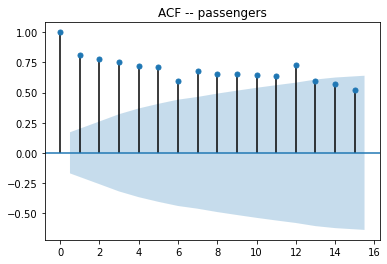

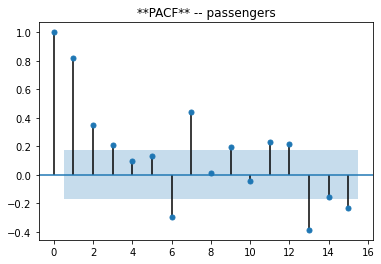

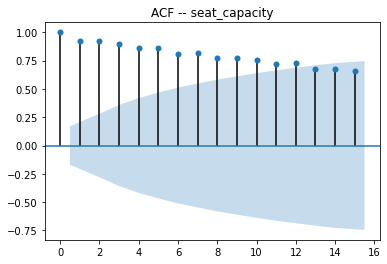

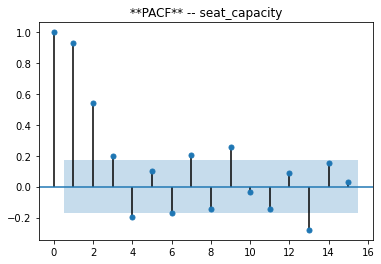

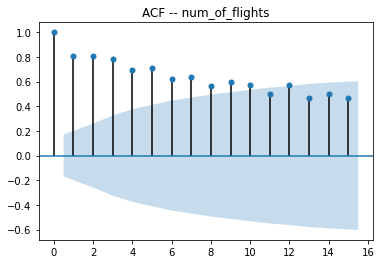

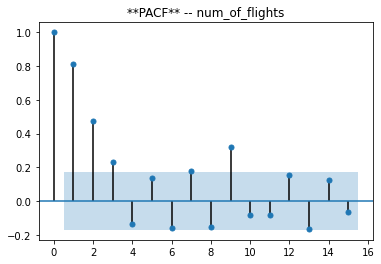

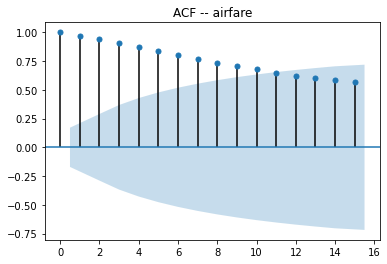

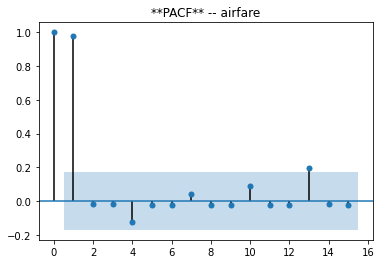

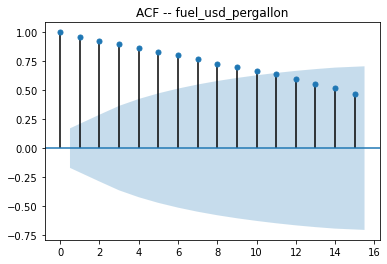

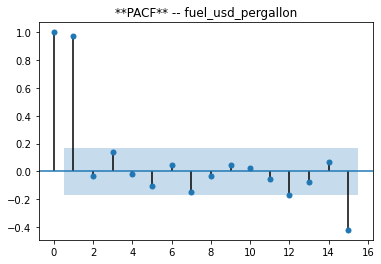

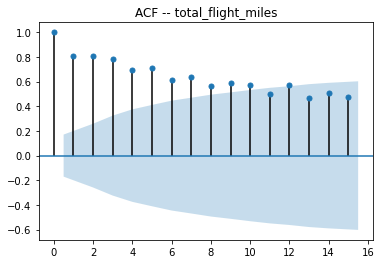

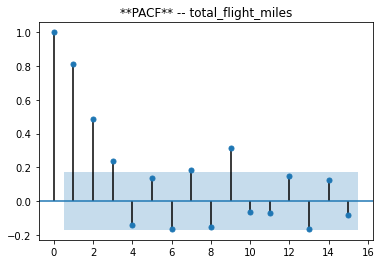

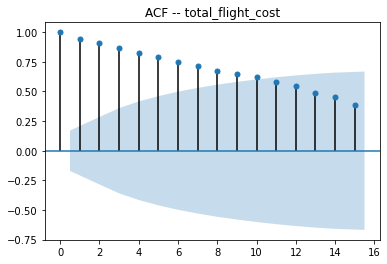

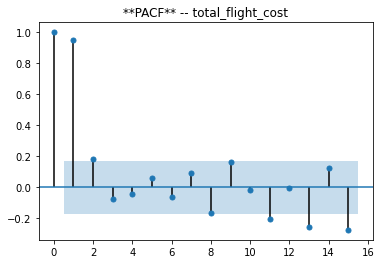

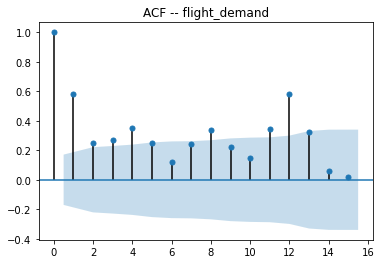

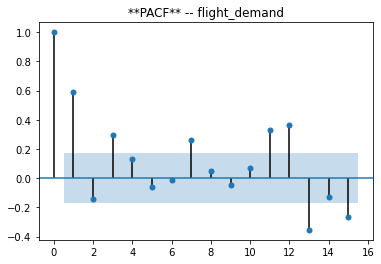

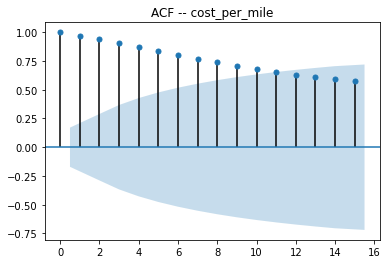

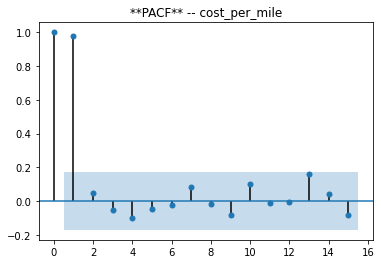

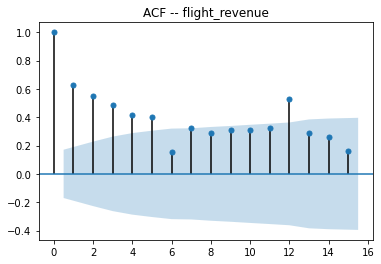

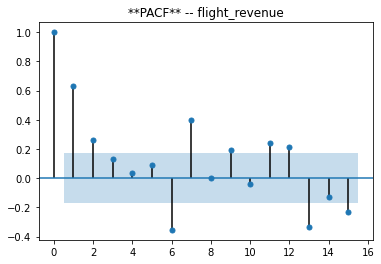

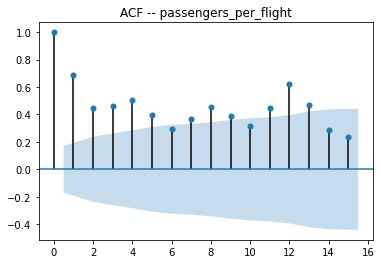

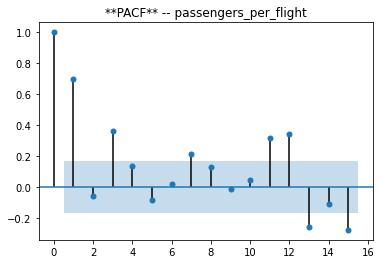

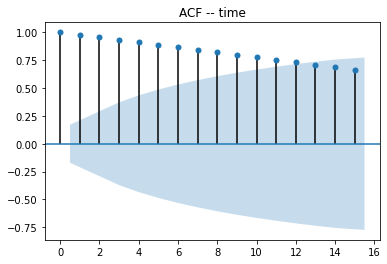

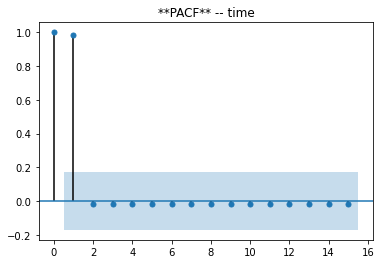

In [639]:
for column in route._get_numeric_data().drop(columns=drop_columns).columns:
    plot_acf(route[column], lags=15, alpha=0.05, title='ACF -- ' + str(column))
    plot_pacf(route[column], lags=15, alpha=0.05, title='**PACF** -- ' + str(column))

In [640]:
route._get_numeric_data().drop(columns=drop_columns).columns

Index(['passengers', 'seat_capacity', 'num_of_flights', 'airfare',
       'fuel_usd_pergallon', 'total_flight_miles', 'total_flight_cost',
       'flight_demand', 'cost_per_mile', 'flight_revenue',
       'passengers_per_flight', 'time'],
      dtype='object')

In [641]:
route

,route,passengers,seat_capacity,num_of_flights,dist_miles,pop_origin,pop_dest,airfare,origin_lat,origin_long,dest_lat,dest_long,fuel_usd_pergallon,total_flight_miles,total_flight_cost,flight_demand,cost_per_mile,flight_revenue,passengers_per_flight,time
year-month,,,,,,,,,,,,,,,,,,,,
1996-01-31,"Dallas, TX - Houston, TX",171953,303705,2870,229.586207,8994450,4268132,78.20,32.9,97.03,29.97,95.35,0.550,658912.413793,3.624018e+05,0.566184,0.340613,13446724.60,59.913937,0
1996-02-29,"Dallas, TX - Houston, TX",170314,281305,2684,228.793103,8994450,4268132,78.20,32.9,97.03,29.97,95.35,0.557,614080.689655,3.420429e+05,0.605442,0.341794,13318554.80,63.455291,1
1996-03-31,"Dallas, TX - Houston, TX",201251,301331,2877,229.777778,8994450,4268132,78.20,32.9,97.03,29.97,95.35,0.586,661070.666667,3.873874e+05,0.667874,0.340329,15737828.20,69.951686,2
1996-04-30,"Dallas, TX - Houston, TX",179483,293973,2801,229.225806,8994450,4268132,76.01,32.9,97.03,29.97,95.35,0.617,642061.483871,3.961519e+05,0.610542,0.331594,13642502.83,64.078186,3
1996-05-31,"Dallas, TX - Houston, TX",190072,298747,2837,230.709677,8994450,4268132,76.01,32.9,97.03,29.97,95.35,0.557,654523.354839,3.645695e+05,0.636231,0.329462,14447372.72,66.997533,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-08-31,"Dallas, TX - Houston, TX",132454,196420,2106,229.720000,11998822,5484883,103.41,32.9,97.03,29.97,95.35,2.133,483790.320000,1.031925e+06,0.674341,0.450157,13697068.14,62.893637,127
2006-09-30,"Dallas, TX - Houston, TX",123124,182170,1942,228.760000,11998822,5484883,103.41,32.9,97.03,29.97,95.35,1.810,444251.920000,8.040960e+05,0.675874,0.452046,12732252.84,63.400618,128
2006-10-31,"Dallas, TX - Houston, TX",135302,194507,2054,228.321429,11998822,5484883,102.56,32.9,97.03,29.97,95.35,1.739,468972.214286,8.155427e+05,0.695615,0.449191,13876573.12,65.872444,129


In [642]:
# After viewing our ACF & PACF plots we can move forward with creation of seasonality and trend based features.  
# Here is a function we can apply to our dataframes

def seasonal_trend_features(df):
    
    df = df.copy()
    
    # Seasonality - 12 month
    df['passengers_lag_12'] = df['passengers'].shift(12)
    df['num_of_flights_lag_12'] = df['num_of_flights'].shift(12)
    df['flight_demand_lag_12'] = df['flight_demand'].shift(12)
    df['passengers_per_flight_lag_12'] = df['passengers_per_flight'].shift(12)
    df['flight_revenue_lag_12'] = df['flight_revenue'].shift(12)
    df['flight_demand_lag_12'] = df['flight_demand'].shift(12)
    
    # Trend - 1 month
    df['passengers_lag_1'] = df['passengers'].shift(1)
    df['seat_capacity_lag_1'] = df['seat_capacity'].shift(1)
    df['num_of_flights_lag_12'] = df['num_of_flights'].shift(1)
    df['airfare_lag_1'] = df['airfare'].shift(1)
    df['fuel_usd_pergallon_lag_1'] = df['fuel_usd_pergallon'].shift(1)
    df['flight_demand_lag_1'] = df['flight_demand'].shift(1)
    df['passengers_per_flight_lag_1'] = df['passengers_per_flight'].shift(1)
    df['flight_demand_lag_1'] = df['flight_demand'].shift(1)
    
    # Trend - 2 month
    df['seat_capacity_lag_2'] = df['seat_capacity'].shift(2)
    df['num_of_flights_lag_2'] = df['num_of_flights'].shift(2)
    
    # Trend - 3 month
    df['num_of_flights_lag_3'] = df['num_of_flights'].shift(3)
    
    # Since we shifted a max of 12 times we should expect 12 rows of NAN values * # of routes in df
    df = df.dropna()
    
    return df

In [643]:
# Apply our seasonal_trend_features function to all datasets for easier reference
# IT IS IMPORTANT WE APPLY THIS NEXT STEP TO EACH INVIDIDUAL ROUTE -- failing to separate by route will be a crucial error for future models

# df_combined
df_combined_seas_trend = pd.DataFrame()
for rte in df_combined['route'].unique():
    df_combined_seas_trend_route = seasonal_trend_features(df_combined[df_combined['route'] == rte])
    df_combined_seas_trend = pd.concat([df_combined_seas_trend, df_combined_seas_trend_route])
df_combined = df_combined_seas_trend

# df_train
df_train_seas_trend = pd.DataFrame()
for rte in df_train['route'].unique():
    df_train_seas_trend_route = seasonal_trend_features(df_train[df_train['route'] == rte])
    df_train_seas_trend = pd.concat([df_train_seas_trend, df_train_seas_trend_route])
df_train = df_train_seas_trend

# df_test
df_test_seas_trend = pd.DataFrame()
for rte in df_test['route'].unique():
    df_test_seas_trend_route = seasonal_trend_features(df_test[df_test['route'] == rte])
    df_test_seas_trend = pd.concat([df_test_seas_trend, df_test_seas_trend_route])
df_test = df_test_seas_trend

# route -- since this is already reduced to an individual route, it can be done this way
route = seasonal_trend_features(route)

### Test for Stationarity & determine what needs differenced
- With time series modeling data must be stationary.  In order to create stationarity we must difference columns.
- We can use the adfuller function in order to check for stationarity
- Reference: [How To Interpret AdFuller Test Results](https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results)

In [644]:
# I've created a function that will ensure our p value and t values meet the threshold to prove the null hypothesis wrong on each dataseries

# Import & Test for Stationary / Non Stationary Data
from statsmodels.tsa.stattools import adfuller  # repeating this again for easy reminder

def stationary_check(dataseries):

    # When data is STATIONARY, then we can reject the null hypothesis that the data is NOT stationary
    
    critical_value = adfuller(dataseries)[0]
    p_value = adfuller(dataseries)[1]
    num_lags = adfuller(dataseries)[2]
    num_obs = adfuller(dataseries)[3]
    t_values = adfuller(dataseries)[4]
    
    diff = 0
    stationary = False
    
    while stationary == False:
        if diff == 0:    
            if (critical_value > t_values['1%']) and (critical_value > t_values['5%']) and (critical_value > t_values['10%']) and (p_value > 0.05):
                diff += 1
            else:
                stationary = True
        if diff == 1:
            critical_value = adfuller(dataseries.diff().dropna())[0]
            t_values = adfuller(dataseries.diff().dropna())[4]
            p_value = adfuller(dataseries.diff().dropna())[1]
            num_lags = adfuller(dataseries.diff().dropna())[2]
            num_obs = adfuller(dataseries.diff().dropna())[3]
            if (critical_value > t_values['1%']) and (critical_value > t_values['5%']) and (critical_value > t_values['10%']) and (p_value > 0.05):
                diff += 1
            else:
                stationary = True
        if diff == 2:
            critical_value = adfuller(dataseries.diff().diff().dropna())[0]
            t_values = adfuller(dataseries.diff().diff().dropna())[4]
            p_value = adfuller(dataseries.diff().diff().dropna())[1]
            num_lags = adfuller(dataseries.diff().diff().dropna())[2]
            num_obs = adfuller(dataseries.diff().diff().dropna())[3]
            if (critical_value > t_values['1%']) and (critical_value > t_values['5%']) and (critical_value > t_values['10%']) and (p_value > 0.05):
                diff += 1
            else:
                stationary = True
        if diff >= 3:
#             print('3 or more diff? Something Is Up!')
            break
    print(dataseries.name)
    print('----------------------------------------------------------------')
    print(f'For Stationarity: {diff} {diff * ".diff()"}')
    print('----------------------------------------------------------------')
    print(f'critical_value: {critical_value}')
    print(f'p_value: {p_value}')
    print(f't_values: {t_values}')
    print(f'number of observations: {num_obs}')
    print(f'number of lags: {num_lags}')
    print()
    np.seterr(divide = 'ignore') # lot's of divide by zero erros -- this turns it off -- "903: RuntimeWarning: divide by zero encountered in log"
    
    return diff

### Looking at each individual route testing for stationarity separately

In [223]:
# started at 3:11:00 -->> 3:23:43 = 12min 43seconds to compute
all_routes_dict = {}
for rte in df_train['route'].unique():
    route_dict = {}
    for column in df_train[df_train['route'] == rte].drop(columns=drop_columns)._get_numeric_data().columns:
        route_dict[column] = stationary_check(df_train[df_train['route'] == rte][column])
    all_routes_dict[rte] = route_dict

#### create a function / formula to difference each route

In [645]:
# Test Output - You can see many columns have different results for stationarity when looking at routes separately
diff_df = pd.DataFrame(all_routes_dict).T
print(diff_df.shape)
diff_df.head(3)

(375, 26)


,passengers,seat_capacity,num_of_flights,airfare,fuel_usd_pergallon,total_flight_miles,total_flight_cost,flight_demand,cost_per_mile,flight_revenue,...,flight_revenue_lag_12,passengers_lag_1,seat_capacity_lag_1,airfare_lag_1,fuel_usd_pergallon_lag_1,flight_demand_lag_1,passengers_per_flight_lag_1,seat_capacity_lag_2,num_of_flights_lag_2,num_of_flights_lag_3
"Albany, NY - Chicago, IL",1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Albuquerque, NM - Chicago, IL",1,1,1,1,1,1,2,1,1,1,...,1,1,1,1,1,1,1,1,1,1
"Albuquerque, NM - Dallas, TX",2,1,0,1,1,0,2,1,1,1,...,1,2,2,0,1,1,1,2,0,0


In [646]:
# We will be creating this number of new columns, however
print(f'Current Number of Columns: {dummy_df.shape[1]}')
print(f'Number of New Columns to Create: {diff_df.max().sum()}')
print(f'Total Number of New Columns When Done: {dummy_df.shape[1] + diff_df.max().sum()}')
print(f'The shape of our train df prior to adding stationary columns: {df_train.shape}')
print('----')
print(f'The shape following creation of train will be: {(45000, 86)}')

Current Number of Columns: 83
Number of New Columns to Create: 52
Total Number of New Columns When Done: 135
The shape of our train df prior to adding stationary columns: (45000, 34)
----
The shape following creation of train will be: (45000, 86)


In [647]:
# this formula will add new columns to each dataframe
def individual_station_create(df, route_key, new_column_dict=all_routes_dict):
    
    new_df = pd.DataFrame()
    
    df = df[df['route'] == route_key].copy()
    
    # let's loop through our all_routes dictionary using 'rte' as they key to access each individual route dictionary
    for key, value in new_column_dict[route_key].items():
        if value == 1:
            df['sf_' + str(key) + '_diff_1'] = df[key].diff()
        if value == 2:
            df['sf_' + str(key) + '_diff_2'] = df[key].diff(2)
    
    new_df = pd.concat([new_df, df])
    
    new_df = new_df.dropna()

    return new_df

In [649]:
# Saving our Dataframs with the new differenced columns

# ONE VERY VERY IMPORTANT THING TO NOTE IS ... there will be a significant amount of NaN values since we difference some columns on specific routes
# and do not difference columns on specific routes
# This is ok as we are going to use the individual route to model the specific route

# we will definitely revisit this as it may have been better to save each dataframe separately to avoid the NANs and dropping them in future

# df_combined
df_combined_stationary = pd.DataFrame()
for rte in df_combined['route'].unique():
    df_combined_stationary_route = individual_station_create(df_combined, rte)
    df_combined_stationary = pd.concat([df_combined_stationary, df_combined_stationary_route])
    
    # Save to file
    df_combined_stationary_route.to_csv('./data/model/by_route/combined/' + rte + '.csv')

df_combined = df_combined_stationary

# df_train
df_train_stationary = pd.DataFrame()
for rte in df_train['route'].unique():
    df_train_stationary_route = individual_station_create(df_train, rte)
    df_train_stationary = pd.concat([df_train_stationary, df_train_stationary_route])
    
    # Save to file
    df_train_stationary_route.to_csv('./data/model/by_route/train/' + rte + '.csv')

df_train = df_train_stationary

# df_test
df_test_stationary = pd.DataFrame()
for rte in df_test['route'].unique():
    df_test_stationary_route = individual_station_create(df_test, rte)
    df_test_stationary = pd.concat([df_test_stationary, df_test_stationary_route])
    
    # Save to file
    df_test_stationary_route.to_csv('./data/model/by_route/test/' + rte + '.csv')
    
df_test = df_test_stationary

# route
route = individual_station_create(route, itinerary)

## Save Datasets for Import for Modeling
- Now that we have pre-processed our data and engineered all of our features let's save the datasets and move on to modeling!

In [654]:
df_combined.to_csv('./data/model/rtm_combined_updated.csv')
df_train.to_csv('./data/model/rtm_train_updated.csv')
df_test.to_csv('./data/model/rtm_test_updated.csv')